### Libraries

In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scikit_posthocs as sp

import re
from transliterate import translit

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('ggplot')

In [2]:
def cohend(X1, X2):
    n1, n2 = X1.size, X2.size
    s1, s2 = X1.std(ddof=1), X2.std(ddof=1)
    m1, m2 = X1.mean(), X2.mean()

    s = (((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))**0.5
    d = (m1-m2)/s
    return d

### Loading data

In [3]:
files = [f for f in listdir('data/') if isfile(join('data/', f))]

l = []
for i, n in enumerate(files):
    df = pd.read_csv('data/'+n, sep=';', decimal=',', encoding='UTF-8')
    l.append(df)
    print(i, end=' ')
    
df = pd.concat(l).reset_index(drop=True)
del files, l

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

### Preprocessing

#### letters translit (taster_name)

In [4]:
print(f'Shape before preprocessing: {df.shape}')
print(f'Shape without duplicates before transliteration: {df.drop_duplicates().shape}')

d = {i: translit(i, language_code='ru', reversed=True) for i in df.taster_name.sort_values().unique() if i is not np.nan}
df.taster_name = df.taster_name.map(d)
del d

df = df.drop_duplicates().reset_index(drop=True)
print(f'Shape without duplicates after transliteration: {df.shape}')
print(f'Number of unique tasters: {df.taster_name.unique().size}')

Shape before preprocessing: (149908, 12)
Shape without duplicates before transliteration: (134061, 12)
Shape without duplicates after transliteration: (119929, 12)
Number of unique tasters: 20


#### Extracting year

In [5]:
df['year'] = df.apply(lambda x: x.title.replace(x.winery, ''), axis=1)
df.loc[df.designation.notna(), 'year']=\
    df.loc[df.designation.notna()].apply(lambda x: x.year.replace(x.designation, ''), axis=1)

df.loc[df.variety.notna(), 'year']=\
    df.loc[df.variety.notna()].apply(lambda x: x.year.replace(x.variety, ''), axis=1)

df.loc[df.region.notna(), 'year']=\
    df.loc[df.region.notna()].apply(lambda x: x.year.replace(x.region, ''), axis=1)

df.loc[df.province.notna(), 'year']=\
    df.loc[df.province.notna()].apply(lambda x: x.year.replace(x.province, ''), axis=1)

df.year = df.year.str.extract('([0-9]{4})')
df.loc[df.year.notna(), 'year'] = df.loc[df.year.notna(), 'year'].astype('int64')

#### Missing values

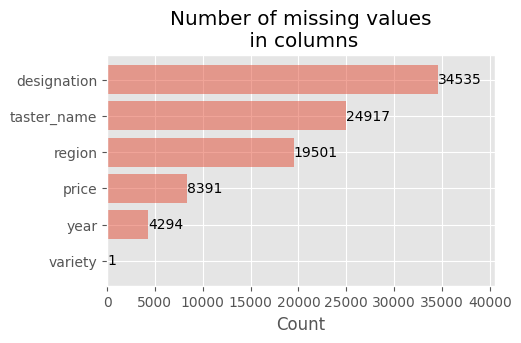

In [6]:
nans = df.isna().sum()
nans = nans.sort_values()[nans>0]

fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.barh(nans.index, nans, alpha=0.5)
ax.bar_label(bars)
ax.set_xlim(right=40500)
plt.title("Number of missing values\n in columns")
plt.xlabel("Count")
plt.show()

In [7]:
df.taster_name = df.taster_name.fillna('other') # let's create new category 'unknown' as taster name
df.loc[df.variety.isna(), 'variety'] = 'Cabernet Sauvignon' # 1 missing value of variety (let's google it)

In [8]:
# Price
# Let's fill missing values by mean in groups of designation, winery, region and province
# variety and year would control mean of groups

df.price = df.price.fillna(df.groupby(['designation', 'variety', 'year']).price.transform(lambda x: x.fillna(x.mean())))
df.price = df.price.fillna(df.groupby(['winery', 'variety', 'year']).price.transform(lambda x: x.fillna(x.mean())))
df.price = df.price.fillna(df.groupby(['region', 'variety', 'year']).price.transform(lambda x: x.fillna(x.mean())))
df.price = df.price.fillna(df.groupby(['province', 'variety', 'year']).price.transform(lambda x: x.fillna(x.mean())))

In [9]:
# Region, Designation
# Both have too many NaNs and we already have information of winery and province, so let's remove them

df = df.drop(['region', 'designation'], axis=1)

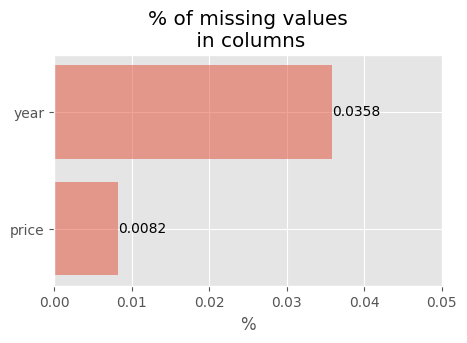

In [10]:
# in percent
nans2 = (df.isna().sum()/df.entry_id.count()).round(4)
nans2 = nans2.sort_values()[nans2>0]

fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.barh(nans2.index, nans2, alpha=0.5)
ax.bar_label(bars)
ax.set_xlim(right=0.05)
plt.title("% of missing values\n in columns")
plt.xlabel("%")
plt.show()

In [11]:
# Dropping nans and noninformative columns, some outliers

df[(df.points==88.0) & (df.price>3000)] = np.nan
df = df.drop(['entry_id', 'title'], axis=1)
df = df.dropna().reset_index(drop=True)

df.points = df.points.astype('int')

print(f'Shape after handling missing values: {df.shape}')
del nans, nans2

Shape after handling missing values: (115100, 9)


### EDA

In [12]:
# Descriptive statistics:

display(df[['points', 'price']].describe().loc[['mean', '50%', 'std']].rename({'50%':'median'}))

,points,price
mean,88.482798,36.795690
median,88.000000,26.000000
std,3.094715,42.920319


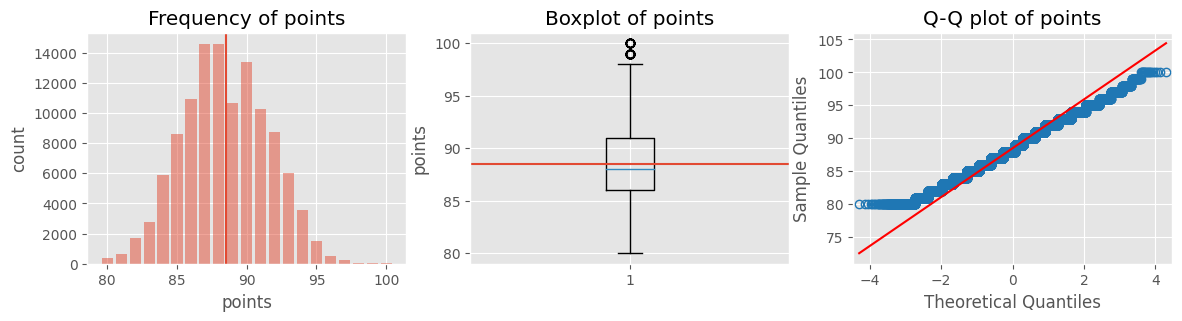

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
ax[0].bar(df.points.value_counts().index, df.points.value_counts(), alpha=0.5)
ax[0].axvline(df.points.mean())
ax[0].set_title("Frequency of points")
ax[0].set_xlabel("points")
ax[0].set_ylabel("count")

ax[1].boxplot(df.points)
ax[1].axhline(df.points.mean())
ax[1].set_title("Boxplot of points")
ax[1].set_ylabel("points")

sm.qqplot(df.points, line ='q', markerfacecolor='None', markeredgecolor='#1f77b4', ax=ax[2])
ax[2].set_title("Q-Q plot of points")
plt.show()

In [14]:
s, p = sm.stats.lilliefors(df.points, dist="exp")
print(f'Kolmogorov-Smirnov test: {round(s, 5)}, p-value: {round(p, 5)}')

Kolmogorov-Smirnov test: 0.59647, p-value: 0.001


In [15]:
# p-value: 0.00 < 0.05, H0 should be rejected
# distribution come from non-normal distributed population

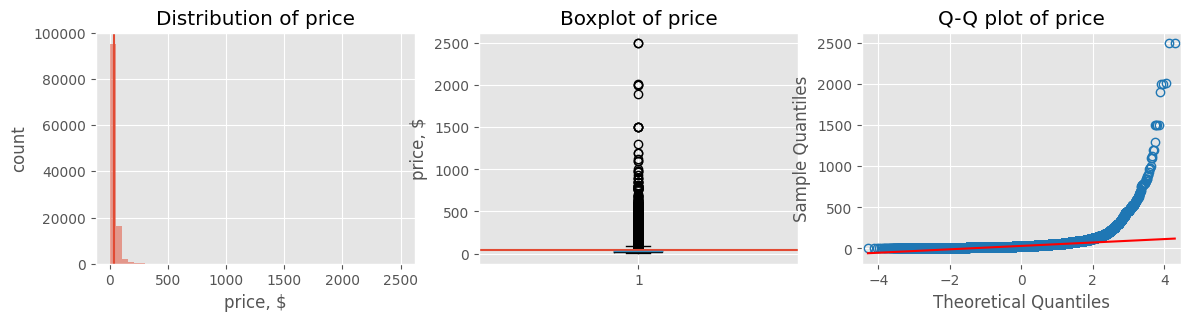

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
ax[0].hist(df.price, bins=50, alpha=0.5)
ax[0].axvline(df.price.mean())
ax[0].set_title("Distribution of price")
ax[0].set_xlabel("price, $")
ax[0].set_ylabel("count")

ax[1].boxplot(df.price)
ax[1].axhline(df.price.mean())
ax[1].set_title("Boxplot of price")
ax[1].set_ylabel("price, $")

sm.qqplot(df.price, line ='q', markerfacecolor='None', markeredgecolor='#1f77b4', ax=ax[2])
ax[2].set_title("Q-Q plot of price")
plt.show()

In [17]:
df['price_log'] = np.log(df.price)

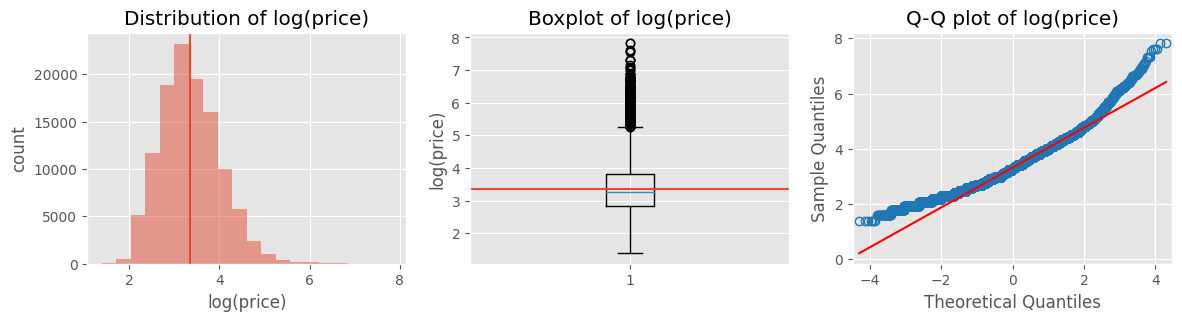

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
ax[0].hist(df.price_log, bins=20, alpha=0.5)
ax[0].axvline(df.price_log.mean())
ax[0].set_title("Distribution of log(price)")
ax[0].set_xlabel("log(price)")
ax[0].set_ylabel("count")

ax[1].boxplot(df.price_log)
ax[1].axhline(df.price_log.mean())
ax[1].set_title("Boxplot of log(price)")
ax[1].set_ylabel("log(price)")

sm.qqplot(df.price_log, line ='q', markerfacecolor='None', markeredgecolor='#1f77b4', ax=ax[2])
ax[2].set_title("Q-Q plot of log(price)")
plt.show()

In [19]:
s, p = sm.stats.lilliefors(df.price_log, dist="norm")
print(f'Kolmogorov-Smirnov test: {round(s, 5)}, p-value: {round(p, 5)}')

Kolmogorov-Smirnov test: 0.06714, p-value: 0.001


In [20]:
# p-value also less a significance_level (0.05), H0 should be rejected
# distribution come from non-normal distributed population

#### Correlation

In [21]:
s, p = st.spearmanr(df.price_log, df.points)
print(f"Spearman's r: {round(s, 5)}, p-value: {round(p, 5)}")
s, p = st.kendalltau(df.price_log, df.points)
print(f"kendall's tau: {round(s, 5)}, p-value: {round(p, 5)}")

Spearman's r: 0.60556, p-value: 0.0
kendall's tau: 0.45234, p-value: 0.0


#### Regression

In [22]:
df['const'] = 1

In [23]:
model1 = sm.OLS(df.points, df[['const', 'price_log']]).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 6.769e+04
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:23:59   Log-Likelihood:            -2.6673e+05
No. Observations:              115100   AIC:                         5.335e+05
Df Residuals:                  115098   BIC:                         5.335e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0653      0.037   2141.849      0.0

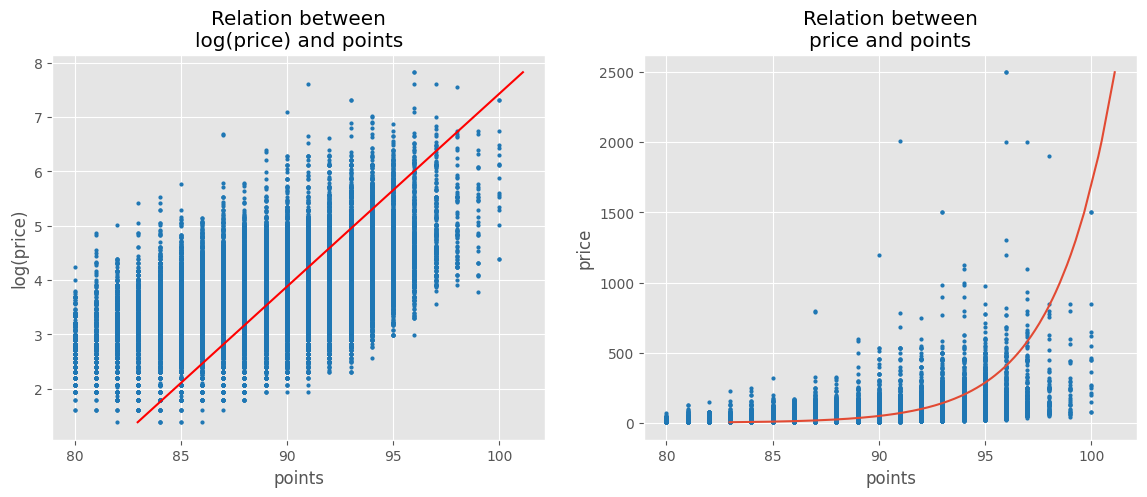

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

reg = pd.DataFrame({'price_log': df.price_log, 'price': df.price, 'points': model1.predict(df[['const', 'price_log']])})\
      .sort_values(by='points')


ax[0].plot(df.points, df.price_log, 'o',  c='#1f77b4', markersize=2)
ax[0].plot(reg.points, reg.price_log, c='red')
ax[0].set_title("Relation between\nlog(price) and points")
ax[0].set_ylabel("log(price)")
ax[0].set_xlabel("points")

ax[1].plot(df.points, df.price, 'o',  c='#1f77b4', markersize=2)
ax[1].plot(reg.points, reg.price)
ax[1].set_title("Relation between\nprice and points")
ax[1].set_ylabel("price")
ax[1].set_xlabel("points")

plt.show()

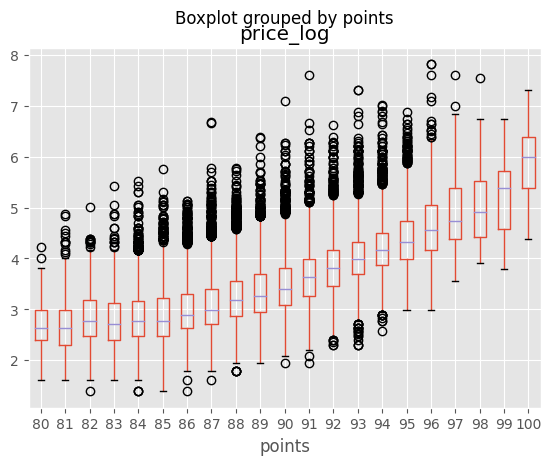

In [25]:
df.boxplot(column='price_log', by='points')
plt.show()

#### By countries

In [26]:
# Гипотеза: страна происхождения вина вляет на оценку

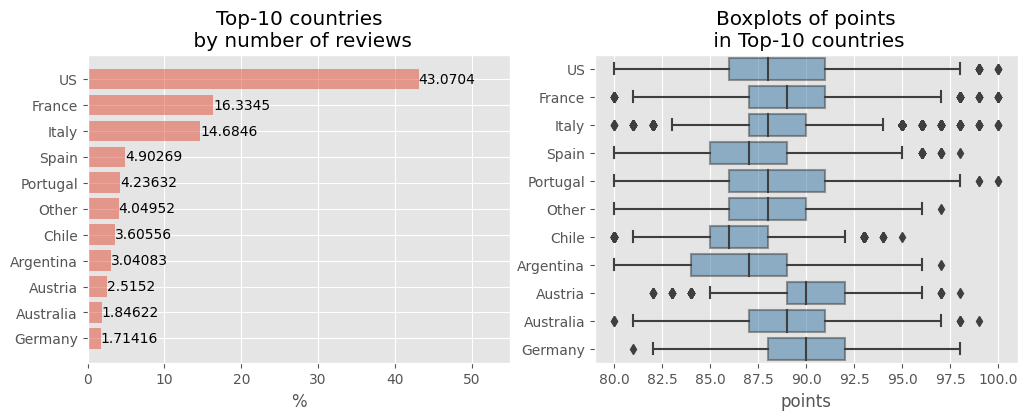

In [27]:
p = df.country.value_counts().sort_values(ascending=True).tail(10)
df.loc[~df.country.isin(p.index), 'country'] = 'Other'

p = df.country.value_counts().sort_values(ascending=True)/115100*100

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
bars = ax[0].barh(p.index, p, alpha=0.5)
ax[0].bar_label(bars)
ax[0].set_xlim(right=55)
ax[0].set_title("Top-10 countries\n by number of reviews")
ax[0].set_xlabel("%")

sns.boxplot(data=df, x="points", y="country", color='#1f77b4', boxprops=dict(alpha=.5), order=p.index[::-1], ax=ax[1])
ax[1].set_title("Boxplots of points\n in Top-10 countries")
ax[1].set_xlabel("points")
ax[1].set_ylabel("")

plt.show()

In [28]:
points = [df.loc[ids, 'points'].values for ids in df.groupby('country').groups.values()]

In [29]:
print(f'Test on homogeneity of variances: \n{st.levene(*points, center="median")}')

Test on homogeneity of variances: 
LeveneResult(statistic=173.2612689995314, pvalue=0.0)


In [30]:
# pvalue less than significance level, H0 is rejected. Variances of points in all groups are not equal.

In [31]:
print(f'Comparison of mean rank sum in all groups: \n{st.kruskal(*points)}')

Comparison of mean rank sum in all groups: 
KruskalResult(statistic=5403.690085559578, pvalue=0.0)


In [32]:
# pvalue < 0.05, H0 is rejected. We have at least one pair of groups with significant difference at points.

Дисперсии выборок различаются

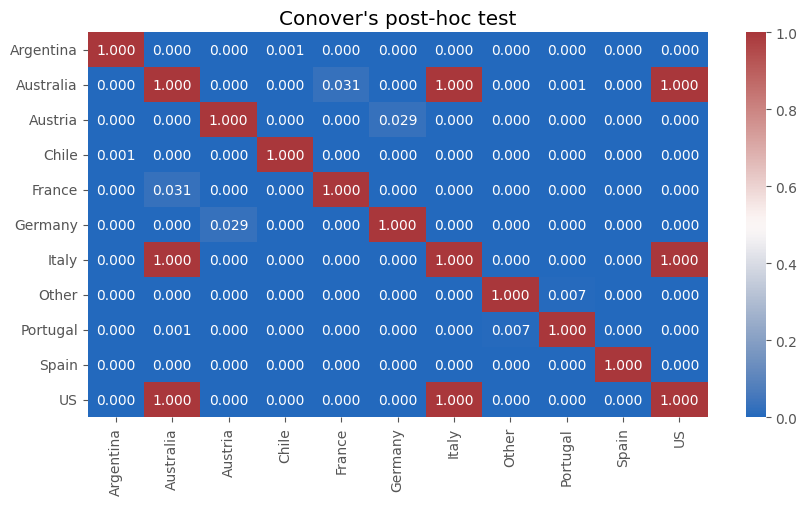

In [33]:
# Conover's post-hoc test:

conover = sp.posthoc_conover(df, val_col='points', group_col='country', p_adjust = 'bonferroni')

plt.figure(figsize=(10, 5))
sns.heatmap(conover, annot=True, fmt=".3f", cmap='vlag')
plt.title("Conover's post-hoc test")
plt.show()

In [34]:
# Compute the effect size:

labels = list(df.groupby('country').groups.keys())

cohen = [[labels[i], labels[j], cohend(n, m)] for j, m in enumerate(points) for i, n in enumerate(points)]

cohen = pd.DataFrame(cohen, columns=['country1', 'country2', 'cohen']).pivot(columns='country1', index='country2', values='cohen')

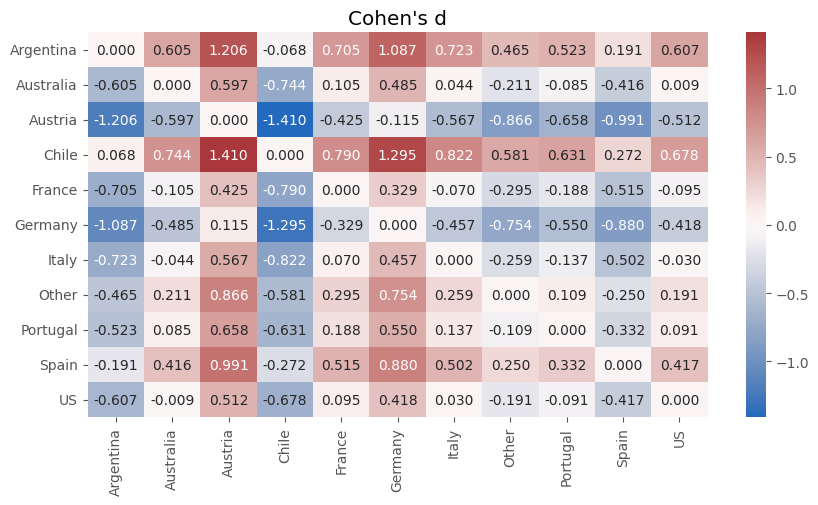

In [35]:
plt.figure(figsize=(10, 5))
sns.heatmap(cohen, annot=True, fmt=".3f", cmap='vlag')
plt.title("Сohen's d")
plt.xlabel("")
plt.ylabel("")
plt.show()

#### By Year

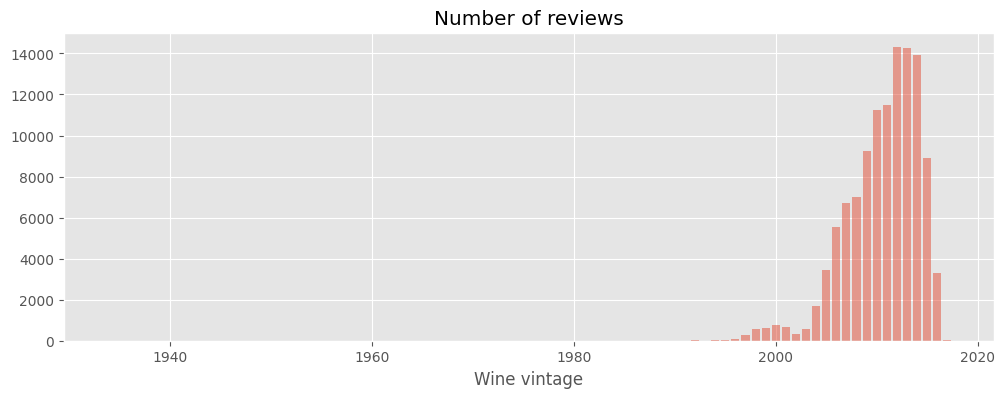

In [36]:
p = df.groupby('year', as_index=False).agg(count=('year', 'count')).sort_values(by='year', ascending=False)
fig, ax = plt.subplots(figsize=(12, 4))
plt.bar(p['year'], p['count'], alpha=0.5)
plt.title("Number of reviews")
plt.xlabel("Wine vintage")

plt.show()

In [37]:
df['year_label'] = np.nan
df.loc[df.year<=1990, 'year_label'] = '1934-1990'
df.loc[(df.year>1990)&(df.year<=2000), 'year_label'] = '1991-2000'
df.loc[(df.year>2000)&(df.year<=2005), 'year_label'] = '2001-2005'
df.loc[(df.year>2005)&(df.year<=2010), 'year_label'] = '2005-2010'
df.loc[(df.year>2010)&(df.year<=2015), 'year_label'] = '2010-2014'
df.loc[df.year>2015, 'year_label'] = '2015-2017'

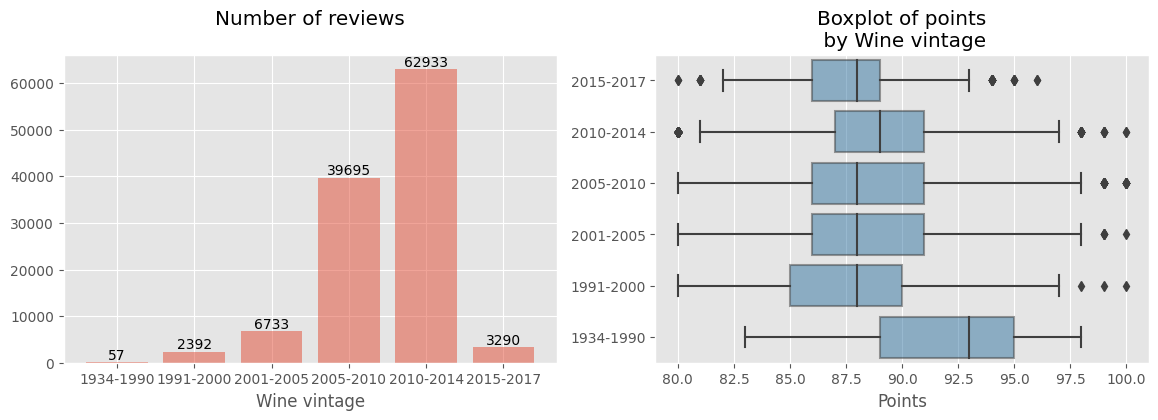

In [38]:
p = df.groupby('year_label', as_index=False).agg(count=('year_label', 'count'))

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
bars = ax[0].bar(p['year_label'], p['count'], alpha=0.5)
ax[0].bar_label(bars)
ax[0].set_title("Number of reviews\n ")
ax[0].set_xlabel("Wine vintage")


sns.boxplot(data=df, x="points", y="year_label", color='#1f77b4', boxprops=dict(alpha=.5), order=p.year_label[::-1], ax=ax[1])
ax[1].set_title("Boxplot of points\n by Wine vintage")
ax[1].set_xlabel("Points")
ax[1].set_ylabel("")

plt.show()

In [39]:
points = [df.loc[ids, 'points'].values for ids in df.groupby('year_label').groups.values()]

In [40]:
print(f'Test on homogeneity of variances: \n{st.levene(*points, center="median")}')

Test on homogeneity of variances: 
LeveneResult(statistic=137.12898620301814, pvalue=1.7093419492873095e-145)


In [41]:
# pvalue less than significance level, H0 is rejected. Variances of points in all groups are not equal.

In [42]:
print(f'Comparison of mean rank sum in all groups: \n{st.kruskal(*points)}')

Comparison of mean rank sum in all groups: 
KruskalResult(statistic=1091.4373815851952, pvalue=9.558596837078036e-234)


In [43]:
# pvalue < 0.05, H0 is rejected. We have at least one pair of groups with significant difference at points.

In [44]:
# Compute the effect size:

labels = list(df.groupby('year_label').groups.keys())
cohen = [[labels[i], labels[j], cohend(n, m)] for j, m in enumerate(points) for i, n in enumerate(points)]
cohen = pd.DataFrame(cohen, columns=['year1', 'year2', 'cohen']).pivot(columns='year1', index='year2', values='cohen')

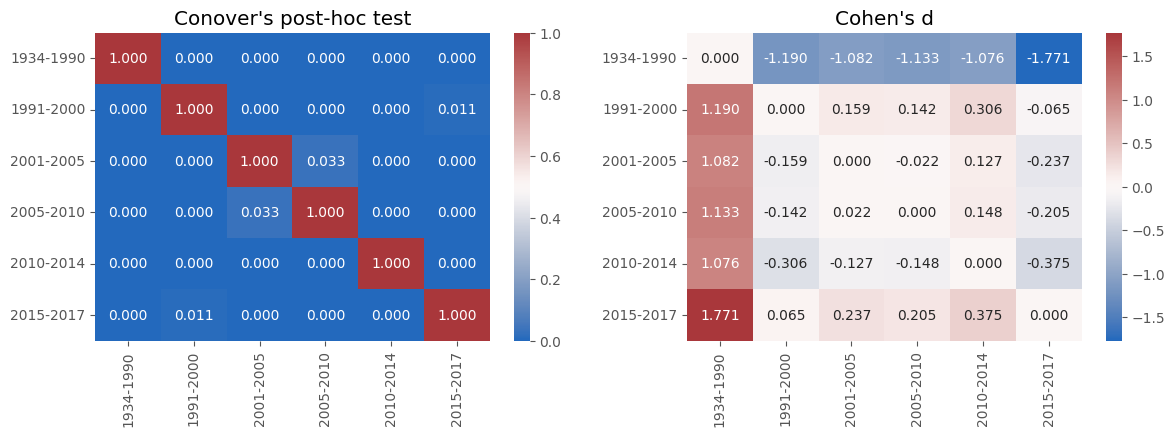

In [45]:
# Conover's post-hoc test:

conover = sp.posthoc_conover(df, val_col='points', group_col='year_label', p_adjust = 'bonferroni')

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.heatmap(conover, annot=True, fmt=".3f", cmap='vlag', ax=ax[0])
ax[0].set_title("Conover's post-hoc test")

sns.heatmap(cohen, annot=True, fmt=".3f", cmap='vlag', ax=ax[1])
ax[1].set_title("Сohen's d")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
plt.show()

#### By tasters

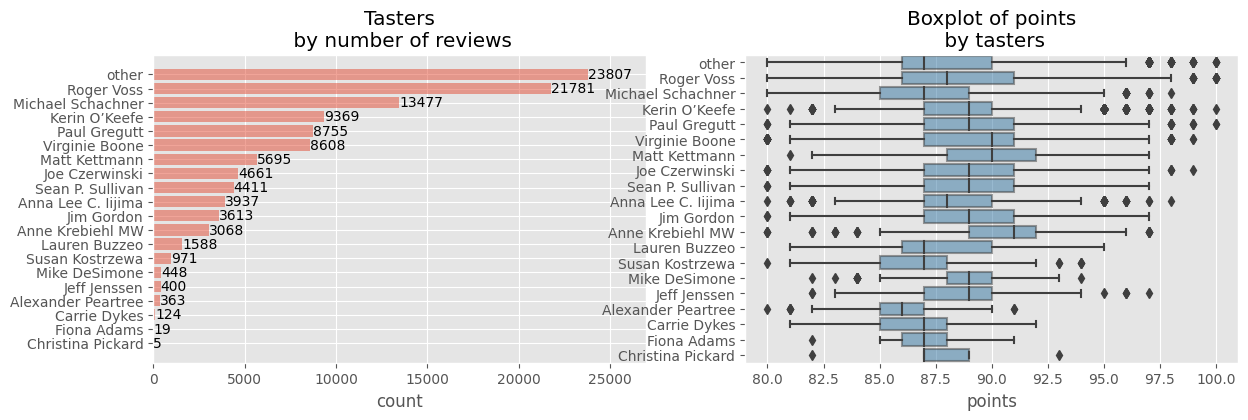

In [46]:
p = df.groupby('taster_name', as_index=False).agg(count=('taster_name', 'count')).sort_values(by='count')

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
bars = ax[0].barh(p['taster_name'], p['count'], alpha=0.5)
ax[0].bar_label(bars)
ax[0].set(title='Tasters\n by number of reviews', xlabel='count')
ax[0].set_xlim(right=27000)

sns.boxplot(data=df, x="points", y="taster_name", color='#1f77b4', boxprops=dict(alpha=.5), order=p.taster_name[::-1], ax=ax[1])
ax[1].set(title='Boxplot of points\n by tasters', ylabel=None) # , yticks=[]

plt.show()

In [47]:
df.loc[df.taster_name.isin(p.loc[p['count'] < 30,'taster_name']),'taster_name'] = 'other'

In [48]:
points = [df.loc[ids, 'points'].values for ids in df.groupby('taster_name').groups.values()]

In [49]:
print(f'Test on homogeneity of variances: \n{st.levene(*points, center="median")}')

Test on homogeneity of variances: 
LeveneResult(statistic=141.15212937059133, pvalue=0.0)


In [50]:
# pvalue less than significance level, H0 is rejected. Variances of points in all groups are not equal.

In [51]:
print(f'Comparison of mean rank sum in all groups: \n{st.kruskal(*points)}')

Comparison of mean rank sum in all groups: 
KruskalResult(statistic=9784.627911679607, pvalue=0.0)


In [52]:
# pvalue < 0.05, H0 is rejected. We have at least one pair of groups with significant difference at points.

In [53]:
# Compute the effect size:

labels = list(df.groupby('taster_name').groups.keys())
cohen = [[labels[i], labels[j], cohend(n, m)] for j, m in enumerate(points) for i, n in enumerate(points)]
cohen = pd.DataFrame(cohen, columns=['taster1', 'taster2', 'cohen']).pivot(columns='taster1', index='taster2', values='cohen')

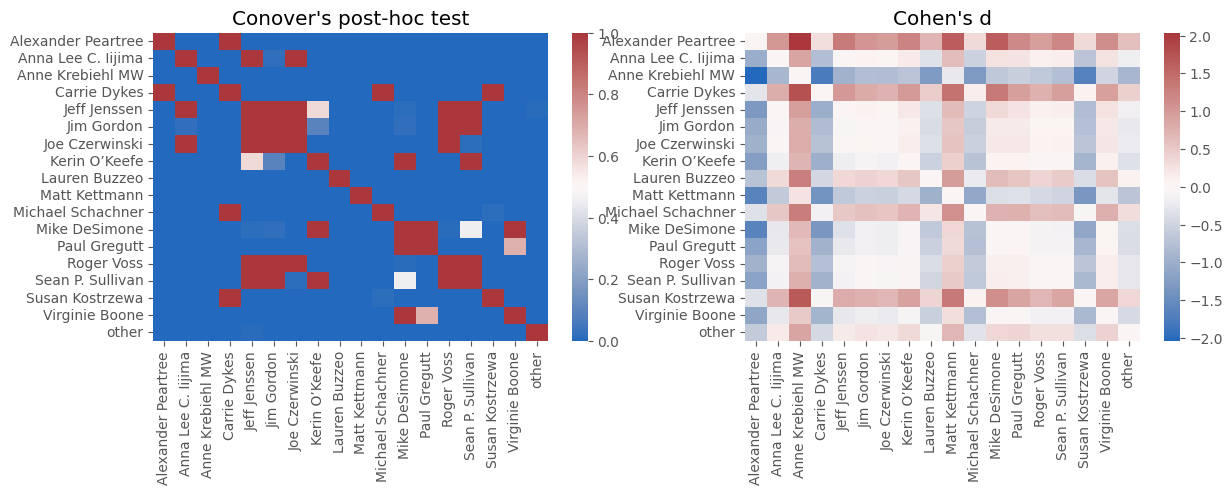

In [54]:
# Conover's post-hoc test:

conover = sp.posthoc_conover(df, val_col='points', group_col='taster_name', p_adjust = 'bonferroni')

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.heatmap(conover, annot=False, fmt=".3f", cmap='vlag', ax=ax[0])
ax[0].set_title("Conover's post-hoc test")

sns.heatmap(cohen, annot=False, fmt=".3f", cmap='vlag', ax=ax[1])
ax[1].set_title("Сohen's d")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
plt.show()

#### Regression

In [55]:
# filtering

groups = df.groupby(['country', 'year_label', 'taster_name'], as_index=False).agg(count=('points', 'count')).sort_values('count')
groups2 = groups.groupby(['taster_name'], as_index=False).agg(count=('country', 'count')).sort_values('count')
groups = groups[groups.taster_name.isin(groups2[groups2['count']>5].taster_name)]
groups = groups[groups['count']>10]
df = pd.merge(groups, df, on=['country', 'year_label', 'taster_name']).reset_index(drop=True)

In [56]:
model2 = smf.ols('points ~ C(country)', data=df).fit()
model3 = smf.ols('points ~ C(year_label)', data=df).fit()
model4 = smf.ols('points ~ C(taster_name)', data=df).fit()

In [57]:
display(pd.DataFrame([[model1.rsquared, model1.rsquared_adj, model1.fvalue, model1.f_pvalue, model1.aic],
                       [model2.rsquared, model2.rsquared_adj, model2.fvalue, model2.f_pvalue, model2.aic],
                       [model3.rsquared, model3.rsquared_adj, model3.fvalue, model3.f_pvalue, model3.aic],
                       [model4.rsquared, model4.rsquared_adj, model4.fvalue, model4.f_pvalue, model4.aic]],
                      columns=['rsquared', 'rsquared_adj', 'fvalue', 'f_pvalue', 'AIC'],
                      index=['Model 1', 'Model 2', 'Model 3', 'Model 4']).T)

,Model 1,Model 2,Model 3,Model 4
rsquared,0.370309,0.054414,1.098625e-02,0.087863
rsquared_adj,0.370304,0.054320,1.093710e-02,0.087764
fvalue,67687.011077,578.856768,2.234900e+02,880.866065
f_pvalue,0.000000,0.000000,4.762380e-238,0.000000
AIC,533461.779517,511138.558099,5.156460e+05,507517.406196


In [58]:
model5 = smf.ols('points~price_log+C(country)', data=df).fit()
model6 = smf.ols('points~price_log+C(year_label)', data=df).fit()
model7 = smf.ols('points~price_log+C(taster_name)', data=df).fit()

In [59]:
display(pd.DataFrame([[model5.rsquared, model5.rsquared_adj, model5.fvalue, model5.f_pvalue, model5.aic],
                      [model6.rsquared, model6.rsquared_adj, model6.fvalue, model6.f_pvalue, model6.aic],
                      [model7.rsquared, model7.rsquared_adj, model7.fvalue, model7.f_pvalue, model7.aic]],
                     columns=['rsquared', 'rsquared_adj', 'fvalue', 'f_pvalue', 'AIC'],
                     index=['Model 5', 'Model 6', 'Model 7']).T)

,Model 5,Model 6,Model 7
rsquared,0.406950,0.397391,0.430655
rsquared_adj,0.406885,0.397355,0.430587
fvalue,6274.977779,11056.262979,6340.489435
f_pvalue,0.000000,0.000000,0.000000
AIC,464207.095592,465805.663392,460105.400316


In [60]:
model8 = smf.ols('points~price_log+C(taster_name)+C(country)', data=df).fit()
model9 = smf.ols('points~price_log+C(taster_name)+C(year_label)', data=df).fit()

In [61]:
display(pd.DataFrame([[model8.rsquared, model8.rsquared_adj, model8.fvalue, model8.f_pvalue, model8.aic],
                      [model9.rsquared, model9.rsquared_adj, model9.fvalue, model9.f_pvalue, model9.aic]],
                     columns=['rsquared', 'rsquared_adj', 'fvalue', 'f_pvalue', 'AIC'],
                     index=['Model 8', 'Model 9']).T)

,Model 8,Model 9
rsquared,0.440233,0.432037
rsquared_adj,0.440110,0.431941
fvalue,3595.503300,4500.709055
f_pvalue,0.000000,0.000000
AIC,458418.572152,459870.856724


In [62]:
final_model = smf.ols('points~price_log+C(taster_name)+C(country)+C(year_label)', data=df).fit()

In [63]:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     2949.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:24:09   Log-Likelihood:            -2.2904e+05
No. Observations:              100602   AIC:                         4.581e+05
Df Residuals:                  100574   BIC:                         4.584e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

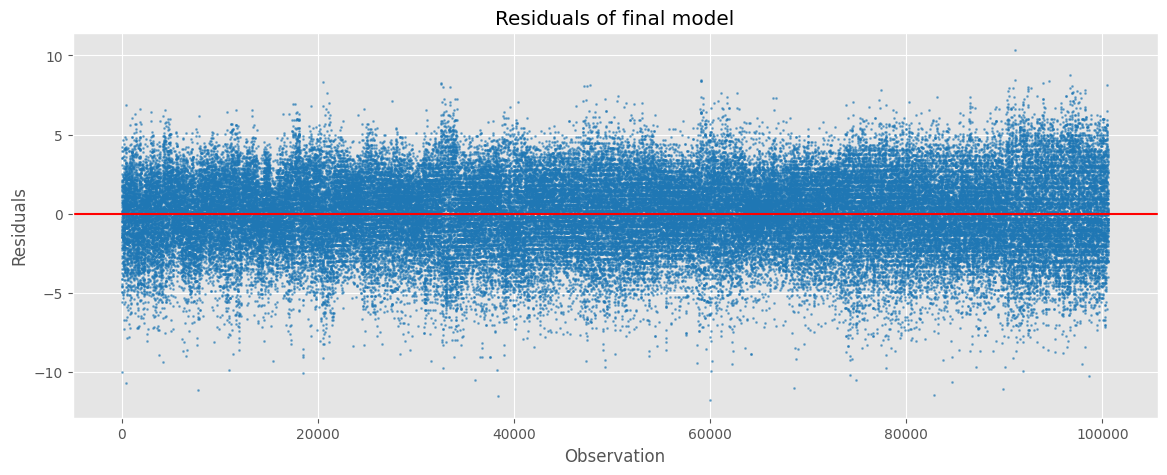

In [64]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(final_model.resid, 'o', markersize=1, c='#1f77b4', alpha=0.5)
plt.axhline(final_model.resid.mean(), color='red')

plt.title("Residuals of final model")
plt.ylabel("Residuals")
plt.xlabel("Observation")
plt.show()

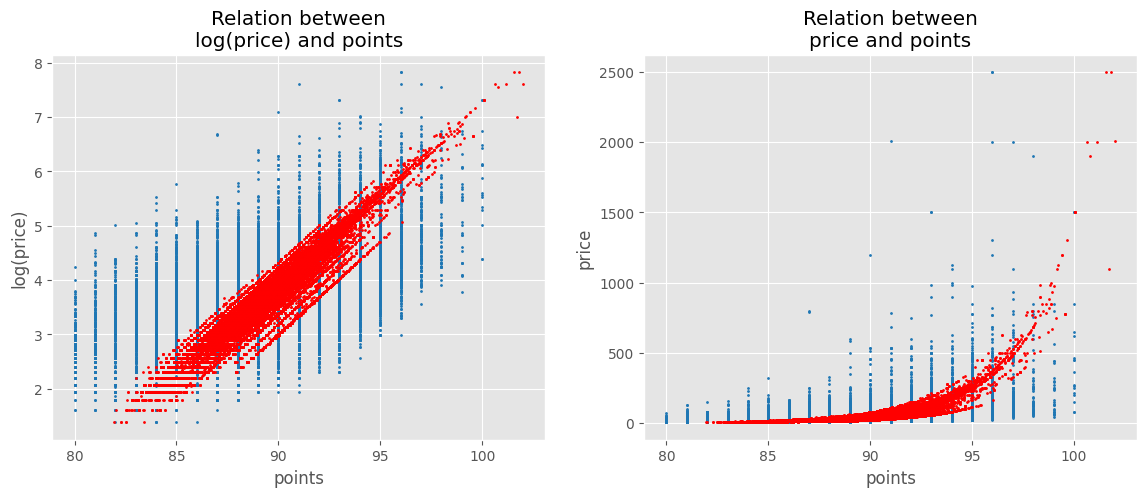

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

reg = pd.DataFrame({'price_log': df.price_log, 
                    'price': df.price, 
                    'points': final_model.predict(df[['points', 'price_log', 'taster_name', 'country', 'year_label']])})\
      .sort_values(by='points')

ax[0].plot(df.points, df.price_log, 'o', markersize=1, c='#1f77b4')
ax[0].plot(reg.points, reg.price_log, 'o', markersize=1, c='red')
ax[0].set_title("Relation between\nlog(price) and points")
ax[0].set_ylabel("log(price)")
ax[0].set_xlabel("points")

ax[1].plot(df.points, df.price, 'o', markersize=1, c='#1f77b4')
ax[1].plot(reg.points, reg.price, 'o', markersize=1, c='red')
ax[1].set_title("Relation between\nprice and points")
ax[1].set_ylabel("price")
ax[1].set_xlabel("points")

plt.show()